In [18]:
# following this tutorial: https://www.projectpro.io/article/how-to-build-arima-model-in-python/544

# import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
# load dataset
df = pd.read_csv("/Users/sahiti/Desktop/Optiver/train.csv")

# using subset of data to create model for right now, all the data is too much
df_subset = df.copy().loc[:28649]
df_subset

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,1.338028e+07,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1.642214e+06,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1.819368e+06,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,1.838975e+07,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,1.786061e+07,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28645,194,2,390,0.00,0,1.000453,1.111537e+07,1.000453,1.000453,1.000453,6620.00,1.000605,19863.00,1.000491,7.669926,149,2_390_194
28646,195,2,390,1800356.76,1,0.999068,4.197746e+07,1.008739,1.003566,0.998956,61477.28,0.999068,20968.60,0.999040,3.169775,149,2_390_195
28647,196,2,390,822686.36,1,0.999261,1.017255e+07,0.999883,0.999883,0.998794,25756.23,0.999261,42797.16,0.998970,1.029968,149,2_390_196
28648,197,2,390,4093.90,-1,1.001636,8.918920e+06,1.001565,1.001636,1.001636,28421.40,1.001778,17960.34,1.001723,-8.109808,149,2_390_197


In [3]:
df_subset["price_spread"] = df_subset["ask_price"] - df_subset["bid_price"]

# creating new imbalance size difference column as differencing 'd' for model
df_subset["imbalance_size_difference"] = df_subset.groupby(['stock_id'])['imbalance_size'].diff(periods=1)

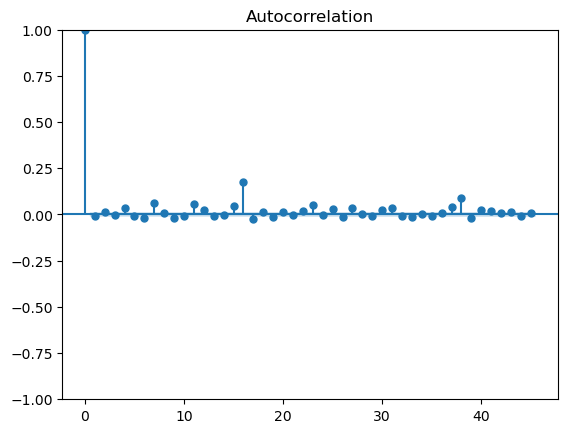

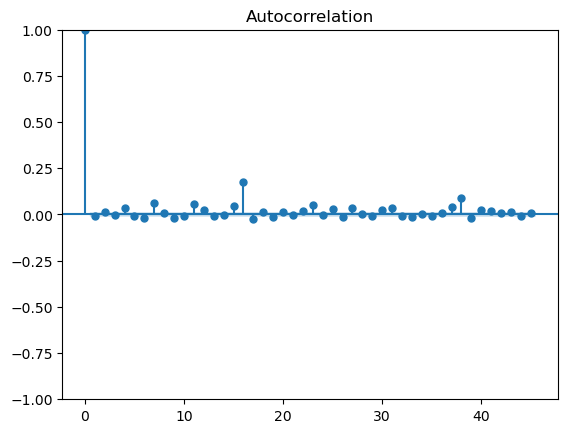

In [4]:
plot_acf(df_subset["imbalance_size"])

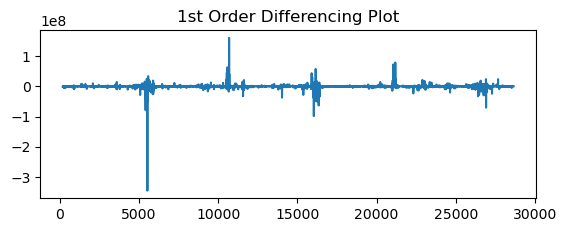

In [7]:
# From the autocorrelation graph, we can decide if more differencing is needed. 
# If collectively the autocorrelations, or the data point of each lag (in the horizontal axis), are positive for several consecutive lags, more differencing might be needed. 
# Conversely, if more data points are negative, the series is over-differenced.

f = plt.figure()
ax1 = f.add_subplot(212)
ax1.set_title("1st Order Differencing Plot")
ax1.plot(df_subset["imbalance_size_difference"])

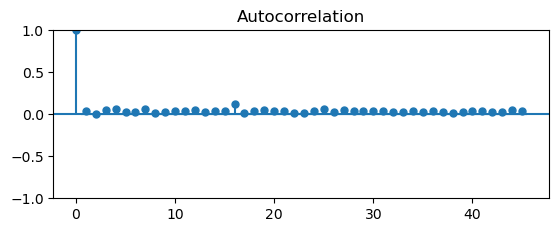

In [10]:
f2 = plt.figure()
ax2 = f2.add_subplot(212)
plot_acf(df_subset["imbalance_size_difference"].dropna(), ax = ax2)
plt.show()

In [14]:
# mathematical: adf test - if p is less than 0.05 the data is stationary, otherwise increase differencing by 1
result = adfuller(df_subset["imbalance_size_difference"].dropna())
print("p-value:", result[1])

# first order differncing is small enough

p-value: 2.99187313310431e-28


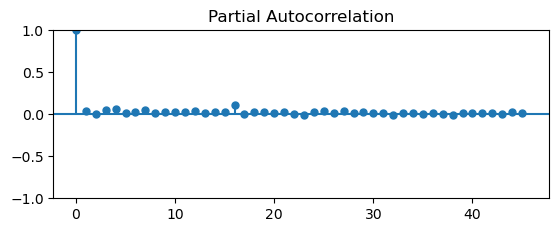

In [17]:
# computing 'p' or the number of lagged (or past) observations to consider for autoregression
# based on the most significant lag in the partial autocorrelation plot

f = plt.figure()
ax2 = f.add_subplot(212)
plot_pacf(df_subset["imbalance_size_difference"].dropna(), ax = ax2)
plt.show()

# most significant is 1

In [ ]:
# determining 'q' or the size of the moving average window
# Looking at the number of lags crossing the threshold, we can determine how much of the past would be significant enough to consider for the future.

# im estimating q = 2 will be good idrk

# final python ARIMA model = ARIMA(p = 1, d = 1, q = 2)

In [20]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df_subset["imbalance_size"], order = (1, 1, 2))
model = arima_model.fit()
print(model.summary())

/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         imbalance_size   No. Observations:                28650
Model:                 ARIMA(1, 1, 2)   Log Likelihood             -513376.628
Date:                Sun, 19 Nov 2023   AIC                        1026761.256
Time:                        10:15:50   BIC                        1026794.307
Sample:                             0   HQIC                       1026771.884
                              - 28650                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9299      0.084    -11.122      0.000      -1.094      -0.766
ma.L1         -0.0749      0.090     -0.836      0.403      -0.251       0.101
ma.L2         -0.9199      0.089    -10.350      0.0

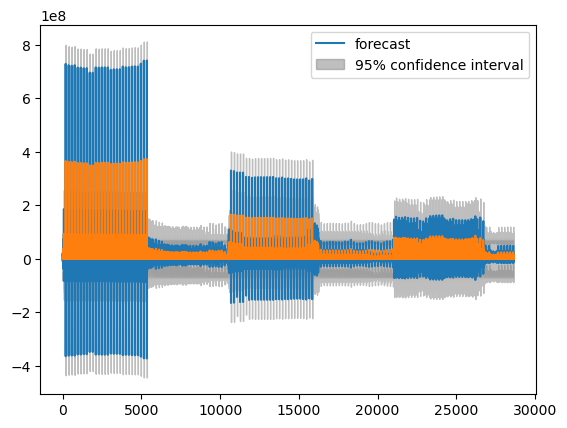

In [26]:
# plotting ARIMA forecast results
from statsmodels.graphics.tsaplots import plot_predict

res = ARIMA(df_subset["imbalance_size"], order=(0,2,0)).fit()
fig, ax = plt.subplots()
plot_predict(res, ax=ax)
ax = df_subset["imbalance_size"].plot(ax=ax)
plt.show()

# not perfectly aligned but in the right direction?? need to figure out how to plot better

In [30]:
# evaluating results of ARIMA forecasting 

# train set
arima_model2 = ARIMA(df_subset["imbalance_size"][:19483], order =(1, 1, 2))
model2 = arima_model2.fit()
print(model2.summary())

/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sahiti/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         imbalance_size   No. Observations:                19483
Model:                 ARIMA(1, 1, 2)   Log Likelihood             -351753.486
Date:                Sun, 19 Nov 2023   AIC                         703514.972
Time:                        10:27:04   BIC                         703546.481
Sample:                             0   HQIC                        703525.294
                              - 19483                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9538      0.070    -13.543      0.000      -1.092      -0.816
ma.L1         -0.0519      0.076     -0.679      0.497      -0.202       0.098
ma.L2         -0.9437      0.076    -12.409      0.0

In [36]:
# test set
y_pred =  pd.Series(model2.forecast(9166), index = df_subset["imbalance_size"][19483:].index)
y_true = df_subset["imbalance_size"][19483:]

print(np.array(y_pred).astype(np.uint8))
print(np.array(y_true))

# either i messed something up this is really really bad

[251 172 217 ... 161 161   0]
[0.00000000e+00 1.84334264e+06 7.88359753e+06 ... 8.22686360e+05
 4.09390000e+03 7.97442643e+06]


/var/folders/11/yxbsb0754zq_bbykx4st33qr0000gn/T/ipykernel_61171/1202150081.py:5: RuntimeWarning: invalid value encountered in cast
  print(np.array(y_pred).astype(np.uint8))


In [40]:
mape = np.mean(np.abs(y_pred - y_true)/ np.abs(y_true)) # mean absolute percentage error
mae = np.mean(np.abs(y_pred - y_true)) # mean absolute error
mpe = np.mean((y_pred - y_true)/ (y_true)) # mean percentage error
rmse = np.mean((y_pred - y_true) ** 2) ** 0.5 
corr = np.corrcoef(y_pred, y_true) [0, 1] # correlation coefficient

print("mape:", mape, ",", "mae: ", mae, ",", "mpe: ", mpe, ",", "rmse: ", rmse, ",", "corr: ", corr)

mape: inf , mae:  3687485.039978957 , mpe:  inf , rmse:  8900311.639941882 , corr:  nan
